In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder


In [4]:
# Проверяем MNIST в TF

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.reshape(60000, -1) / 255.0, x_test.reshape(10000, -1) / 255.0
y_train, y_test = y_train.reshape(-1, 1),y_test.reshape(-1, 1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation=tf.nn.softplus),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train,batch_size=500, epochs=10)
model.evaluate(x_test, y_test)


Epoch 1/10
60000/60000 [==============================] - 3s 55us/step - loss: 2.1696 - acc: 0.2877
Epoch 2/10
60000/60000 [==============================] - 1s 12us/step - loss: 1.6686 - acc: 0.6288
Epoch 3/10
60000/60000 [==============================] - 1s 12us/step - loss: 1.2771 - acc: 0.7196
Epoch 4/10
60000/60000 [==============================] - 1s 12us/step - loss: 1.0013 - acc: 0.7757
Epoch 5/10
60000/60000 [==============================] - 1s 12us/step - loss: 0.8276 - acc: 0.8097
Epoch 6/10
60000/60000 [==============================] - 1s 12us/step - loss: 0.7168 - acc: 0.8302
Epoch 7/10
60000/60000 [==============================] - 1s 12us/step - loss: 0.6422 - acc: 0.8441
Epoch 8/10
60000/60000 [==============================] - 1s 12us/step - loss: 0.5890 - acc: 0.8540
Epoch 9/10
60000/60000 [==============================] - 1s 12us/step - loss: 0.5493 - acc: 0.8605
Epoch 10/10
10000/10000 [==============================] - 0s 49us/step


[0.48088193378448485, 0.8778]

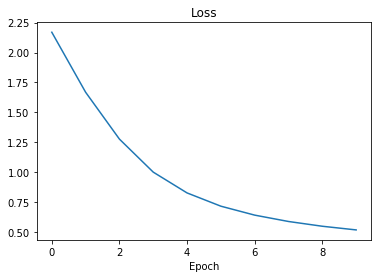

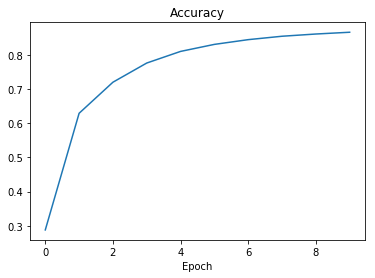

In [5]:
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [15]:
def softmax(X, theta = 1.0, axis = None):
    y = np.atleast_2d(X)
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1) 
    y = y * float(theta)
    y = y - np.expand_dims(np.max(y, axis = axis), axis)
    y = np.exp(y)
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)
    p = y / ax_sum
    if len(X.shape) == 1: p = p.flatten()
    return p

In [16]:
class Layer: pass

class Layer:
    def __init__(self): 
        self.z = None
        self.dZ = None
    def forward(self, X): pass   
    def backward(self, dZ, prev_layer = None): pass
    def update(self, lr): pass

class Flatten(Layer):
    def forward(self, X):
        self.z = X
        return self.z
    
    
class Dropout(Layer):
    def __init__(self, proba = 0.1):
        self.z = None
        self.mask = None
        self.proba = proba
        
    def forward(self, X):
        self.z = X
        self.mask = np.random.choice([0, 1], p=[self.proba, 1-self.proba], size=X.shape)
        return X * self.mask / (1- self.proba)
     
    def backward(self, dZ, prev_layer = None):
        return dZ * self.mask
    def update(self, lr): pass

class ReLU(Layer):    
    def forward(self, X):
        self.z = (X > 0) * X
        return self.z
    
    def backward(self, dZ = None, prev_layer = None):  
        self.dZ = dZ
        return self.dZ * (self.forward(prev_layer.z) * 1)
    
    
class LeakyReLU(Layer):
    def __init__(self,k=0.3):
        self.k=k
    def forward(self, X):  
        self.z = np.copy(X)
        self.z = -self.k *  (self.z < 0)*self.z
        return  self.z
    
    def backward(self, dZ = None, prev_layer = None):
        self.dZ = dZ
        self.dZ = np.copy(prev_layer.z)
        self.dZ = (self.dZ < 0)* -self.k
        self.dZ = (self.dZ >= 0)*1
        return self.dZ * dZ
    
class SoftPlus(Layer):   
    def forward(self, X):
        self.z = np.log(1 + np.exp(X))
        return self.z
    
    def backward(self, dZ = None, prev_layer = None):
        self.dZ = dZ
        return self.dZ * 1/(1+np.exp(-prev_layer.z))

class Sigmoid(Layer):    
    def forward(self, X):
        self.z = 1/(1+np.exp(-X))
        return self.z
    def backward(self, dZ = None, prev_layer = None):
        self.dZ = dZ
        return self.dZ * self.forward(prev_layer.z)*self.forward(1-prev_layer.z)
                 
class SoftMax(Layer):
    def forward(self, X):
        self.z = softmax(X, axis=1)
        return self.z
    def backward(self, dZ, prev_layer = None):
        return self.z - dZ

In [17]:
class Dense(Layer):
    def __init__(self, numb_neur):
        self.W = None
        self.b = None
        self.dW = None
        self.dB = None
        self.numb_neur = numb_neur
       
    def forward(self, X):
        if self.W is None:
            self.W = np.random.normal(loc=0, scale=1, size = (X.shape[1], self.numb_neur))
            self.b = np.random.normal(loc=0, scale=1, size = (1, self.numb_neur))
        self.z = np.dot(X,self.W) + self.b
        return self.z
    
    def backward(self, dZ, prev_layer = None):
        self.dZ = dZ
        self.dB = self.dZ.sum(0) / self.z.shape[0]
        self.dW = np.dot(prev_layer.z.T,self.dZ) / self.z.shape[0]
        return np.dot(self.dZ,self.W.T)
            
    def update(self, lr):
        self.W = self.W - self.dW * lr
        self.b = self.b - self.dB * lr

class Neural:
    def __init__(self, epochs=50, batch_s=100, lr=1.0, lr_decrease=0.001,epoch_drop = 6):
        self.epochs = epochs              # кол-во эпох
        self.batch_s = batch_s            # размер батча
        self.lr = lr                      # learning rate
        self.lr_decrease = lr_decrease    # уменьшение learning rata
        self._epochs_drop = epoch_drop    # каждые N эпох уменьшаем lr 
        self._layers = list()             # слои
        self._encoder = OneHotEncoder(sparse=False,categories='auto') 
    
    #добавление слоев
    def add(self, layer): 
        self._layers.append(layer)
    
    #прямой проход
    def _forward(self, X):
        prev_output = X
        for layer_ind in self._layers:
            prev_output = layer_ind.forward(prev_output)
        return prev_output
    
    # обратный
    def _backward(self, X, y):
        dZ = y
        for index in range(len(self._layers)-1,0,-1):
            dZ = self._layers[index].backward(dZ, prev_layer=self._layers[index-1])
    
    # уменьшение lr (Step Decay)
    def step_decrease(self, init_lr, epoch):
        drop = self.lr_decrease
        lr = init_lr * np.power(drop,np.floor((1+epoch)/self._epochs_drop))
        return lr
    
    #обновляем веса
    def _update(self, epoch):
        for layer_ind in self._layers:
            layer_ind.update(self.step_decrease(self.lr, epoch))
            
    def predict(self, X):
        prediction = self._forward(X)
        return np.argmax(prediction, axis=1)
    
    def _evalute(self, X, Y):
        return(accuracy_score(self.predict(X),Y))
    
    def result(self,xtrain,xtest):
        print("TRAIN loss :",history['loss'][len(history['loss'])-1::])
        print("TRAIN accuracy:",history['accuracy'][len(history['accuracy'])-1::])
        print("TEST accuracy:",self._evalute(xtrain,xtest))
        
    def fit(self, X, y=None):
        history = {'loss': list(), 'accuracy': list()}
        y_old = np.copy(y)
        y = self._encoder.fit_transform(y)
        for epoch in range(self.epochs):
            for ind in range(len(X) // self.batch_s):
                self._forward(X[ind * self.batch_s:(ind+1) * self.batch_s])
                self._backward(X[ind * self.batch_s:(ind+1) * self.batch_s], y[ind * self.batch_s:(ind+1) * self.batch_s])
                self._update(epoch)
        
            history['accuracy'].append(accuracy_score(y_old, self.predict(X)))
            history['loss'].append(log_loss(y, self._forward(X)))
            
        return history

TRAIN loss : [0.4922055681185245]
TRAIN accuracy: [0.8517833333333333]
TEST accuracy: 0.8547


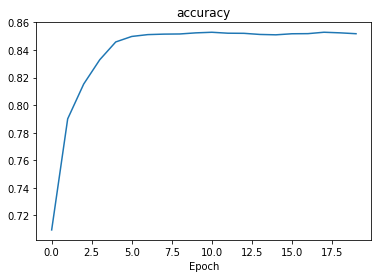

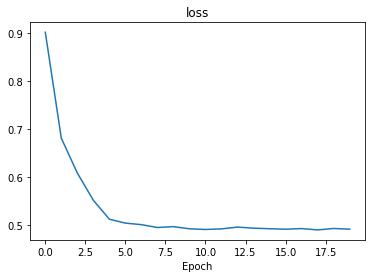

In [27]:
AN = Neural(epochs=20, batch_s=500, lr=1, lr_decrease=0.01,epoch_drop = 6)

AN.add(Flatten())
AN.add(Dense(32))
AN.add(SoftPlus())
AN.add(Dense(32))
AN.add(Sigmoid())
AN.add(Dropout(0.1))
AN.add(Dense(10))
AN.add(SoftMax())
history = AN.fit(x_train, y_train)  
AN.result(x_test, y_test)




plt.plot(history['accuracy'])
plt.title('accuracy')
plt.xlabel('Epoch')
plt.show()
plt.plot(history['loss'])
plt.title('loss')
plt.xlabel('Epoch')
plt.show()

TRAIN loss : [0.406602045582335]
TRAIN accuracy: [0.8808833333333334]
TEST accuracy: 0.8761


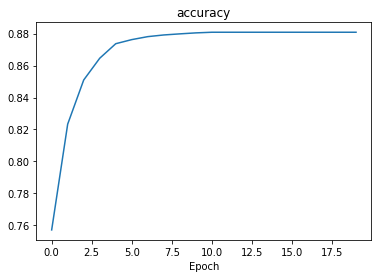

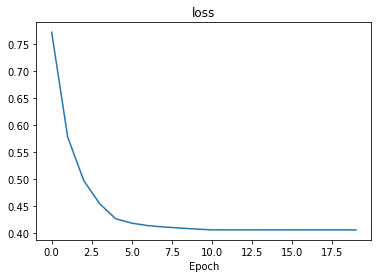

In [26]:
AN = Neural(epochs=20, batch_s=500, lr=1, lr_decrease=0.01,epoch_drop = 6)

AN.add(Flatten())
AN.add(Dense(32))
AN.add(SoftPlus())
AN.add(Dense(32))
AN.add(Sigmoid())
#AN.add(Dropout(0.1))
AN.add(Dense(10))
AN.add(SoftMax())
history = AN.fit(x_train, y_train)  
AN.result(x_test, y_test)




plt.plot(history['accuracy'])
plt.title('accuracy')
plt.xlabel('Epoch')
plt.show()
plt.plot(history['loss'])
plt.title('loss')
plt.xlabel('Epoch')
plt.show()

TRAIN loss : [0.7663371290570558]
TRAIN accuracy: [0.7468166666666667]
TEST accuracy: 0.7543


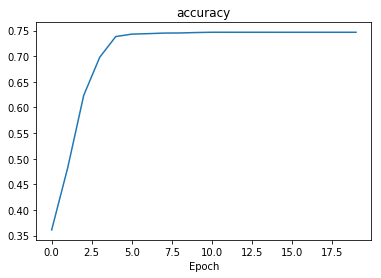

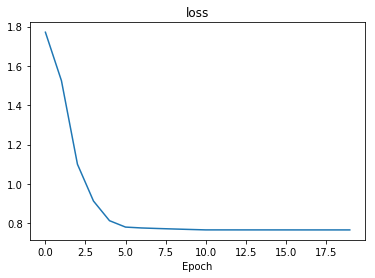

In [28]:
AN = Neural(epochs=20, batch_s=500, lr=1, lr_decrease=0.01,epoch_drop = 6)

AN.add(Flatten())
AN.add(Dense(32))
AN.add(SoftPlus())
AN.add(Dense(10))
AN.add(SoftMax())
history = AN.fit(x_train, y_train)  
AN.result(x_test, y_test)




plt.plot(history['accuracy'])
plt.title('accuracy')
plt.xlabel('Epoch')
plt.show()
plt.plot(history['loss'])
plt.title('loss')
plt.xlabel('Epoch')
plt.show()